# Mini-Project: Parameter estimation for a toy model of an EFT

We begin by importing necessary packages.

In [1]:
import numpy as np
from scipy import stats
import emcee
import corner
import matplotlib.pyplot as plt
%matplotlib inline

### The Model

The underlying toy model of an EFT is 

$$g(x) = \left[\frac{1}{2} + \tan\left(\frac{\pi x}{2}\right)\right]^2.$$

Around $x=0$, the function has the following power series,

$$g(x) = 0.25 + 1.57x + 2.47x^2 + 1.29x^3 + O(x^4),$$

with radius of convergence 1. To order $x^3$, this is how close the power series approximation is to the actual value of $g(x)$.

In [2]:
def g_theory(x: float) -> float:
    # Return the theoretical value of g(x) given x
    return (0.5 + np.tan(np.pi * x / 2)) ** 2

def g_series(x: float, n: int) -> float:
    # Return the power series of g(x) at x up to and include the x^n term; n <= 3
    coefs = [0.25, 1.57, 2.47, 1.29]     # List of coefficients
    return sum([coefs[i] * (x ** i) for i in range(n)])

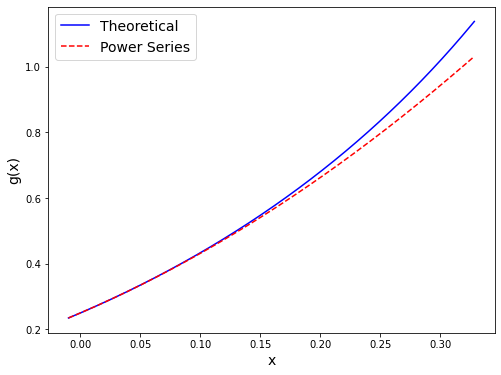

In [3]:
plt.figure(figsize = (8,6))
x_space = np.linspace(-0.01, 0.01+(1/np.pi), 1000)
plt.plot(x_space, g_theory(x_space), "b", label = "Theoretical")
plt.plot(x_space, g_series(x_space, 3), "r--", label = "Power Series")
plt.xlabel("x", fontsize = 14)
plt.ylabel("g(x)", fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

We see that the power series approximation is excellent at small $x$ and diverges slightly from the true value as $x$ increases.

### Generating Data

The data points are randomly generated based on the underlying function, $g(x)$. At each $x$, we generate a data point by

$$d(x) = g(x)\left[1 + 0.05\eta\right],$$

where the value of $\eta$ is randomly assigned from the normal distribution with mean 0 and variance 1. Hence, the width of the distribution of $d(x)$ is 

$$\sigma(x) = 0.05g(x).$$

In the cell below, we generate our own data set just to show how it can be done. An alternative is to use the data set from the file `D1_c_5.dat`, which will exactly reproduce the results in the paper. In both cases, the data points are equally spaced at 10 values of $x\in\left[0,\frac{1}{\pi}\right]$.

In [4]:
def generate_data(n_pts=10, LB=0, UB=1/np.pi, err=0.05):
    # Create the data arrays x and y for n_pts equally spaced values of x,
    # with the lowest being at LB and highest at UB. 
    # For each x, the width of the distribution is err * g(x).
    x = np.linspace(LB, UB, n_pts)
    y = g_theory(x) * (1 + (err * np.random.randn(n_pts)))
    sigma = g_theory(x) * err
    return x, y, sigma

In [5]:
def plot_data(x, y, sigma, err=0.05, error_bar=True):
    # Plot the generated data set with an option to add error bars
    # The red solid line is the theoretical g(x).
    # The two green dashed lines represents 1 SD from g(x) based on err.
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    if error_bar:
        ax.errorbar(x, y, sigma, fmt='o')
    else:
        ax.scatter(x, y)
    x_space = np.linspace(np.min(x) - 0.03 * (np.max(x) - np.min(x)), 
                          np.max(x) + 0.03 * (np.max(x) - np.min(x)), 1000)
    ax.plot(x_space, g_theory(x_space), "r")
    ax.plot(x_space, g_theory(x_space) * (1 + err), "g--")
    ax.plot(x_space, g_theory(x_space) * (1 - err), "g--")
    ax.set_xlabel("x", fontsize = 14)
    ax.set_ylabel("g(x)", fontsize = 14)
    fig.tight_layout()

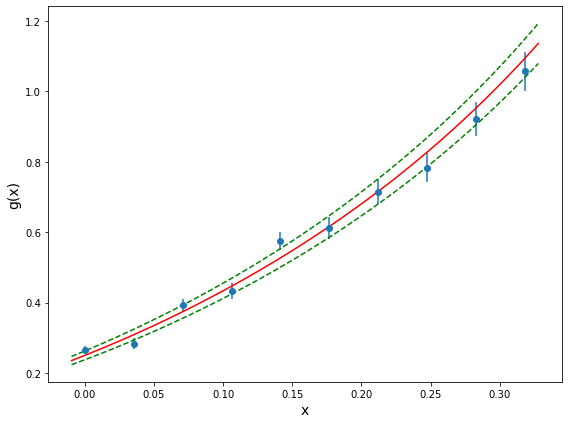

In [6]:
x, y, sigma = generate_data()
plot_data(x, y, sigma)

Alternatively, in order to exactly reproduce the paper's results, we can import the exact same data generated by the authors.

In [7]:
x_paper = np.array([0.03183, 0.06366, 0.09549, 0.12732, 0.15915, 0.19099, 0.22282, 0.25465, 0.28648, 0.31831])
y_paper = np.array([0.31694, 0.33844, 0.42142, 0.57709, 0.56218, 0.68851, 0.73625, 0.87270, 1.0015, 1.0684])
sigma_paper = np.array([0.01585, 0.01692, 0.02107, 0.02885, 0.02811, 0.03443, 0.03681, 0.04364, 0.050075, 0.05342])

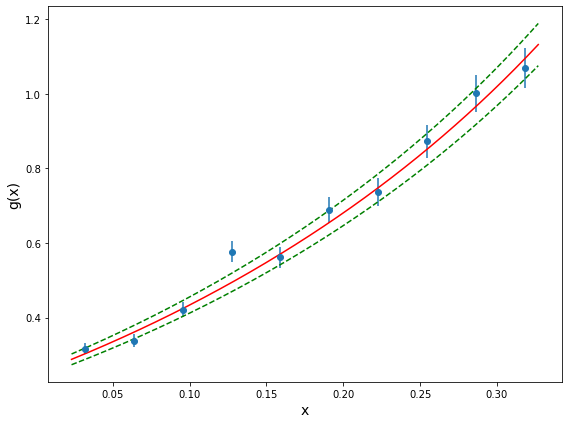

In [8]:
plot_data(x_paper, y_paper, sigma_paper)

Evidently, the data used by the authors are generated with err = 0.05

In [9]:
sigma_paper/y_paper

array([0.05000947, 0.04999409, 0.04999763, 0.0499922 , 0.05000178,
       0.05000654, 0.0499966 , 0.05000573, 0.05      , 0.05      ])

### Probability Functions for Bayesian Analysis

Here, we define the various prior distributions and the Gaussian likelihood function used in the project. They are the main inputs for our Markov-Chain Monte Carlo (MCMC) simulation step.

In [10]:
def log_prior_uniform(a, a_fix = 500):
    # Return the log of the uniform prior with -a_fix <= a_i <= a_fix for each i
    # The original a_fix is tuned to a_fix = 500, the uniform prior used in the paper.
    # Here, a includes both a and a_marg, i.e. it should be an array of length k_max.
    if np.all(a <= a_fix) and np.all(a >= - a_fix):
        return - np.log(2 * a_fix) * len(a)
    return - np.inf

def log_prior_gaussian(a, a_fix = 5):
    # Return the log of the Gaussian prior with a_fix originally set to 5.
    return - (np.sum(a ** 2) / (2 * (a_fix ** 2))) - (len(a) * np.log(a_fix * np.sqrt(2 * np.pi)))

def log_likelihood(a, x, y, sigma):
    # Return the log likelihood according to the Gaussian distribution around the series.
    gth = np.array([np.sum(np.array([a[j] * (x[i] ** j) for j in range(len(a))])) for i in range(len(x))])
    exponent = - 0.5 * np.sum((y - gth) ** 2) / sigma
    return exponent - np.sum(np.log(np.sqrt(2 * np.pi) * sigma))

In [11]:
def log_posterior_uniform(a, x, y, sigma, a_fix=500):
    # Return the log posterior for the uniform prior
    return log_prior_uniform(a, a_fix) + log_likelihood(a, x, y, sigma)

def log_posterior_gaussian(a, x, y, sigma, a_fix=500):
    # Return the log posterior for the Gaussian prior
    return log_prior_gaussian(a, a_fix) + log_likelihood(a, x, y, sigma)

### MCMC Simulation

With the data generated and the log posterior defined, we are now ready to run our MCMC simulation to determine the posterior distribution. Below, the function `MCMC_runner` returns the trace and the log-probability with warm-up steps removed. Marginalization will be done later on when we perform parameter estimation.

In [12]:
def MCMC_runner(x, y, sigma, k_max, a_fix=5, gaussian=False, nwalkers=50, nsteps=5000, nwarmups=500):
    # Runs the MCMC simulation given the data (x,y) and model specifications (k, k_max),
    # together with other optional arguments. 
    # In particular, nwalkers = number of MCMC walkers, nsteps = number of steps per walker
    # and nwarmups = number of warm-up steps per walker.
    # If gaussian is True, the simulation uses the Gaussian prior. Otherwise, use the uniform prior.
    
    print('emcee sampling (version: )', emcee.__version__)

    ndim = k_max + 1  # number of parameters in the model

    print(f'{nwalkers} walkers: {nsteps} samples each')

    # initialize walkers
    starting_guesses = np.random.randn(nwalkers, ndim)
    
    if gaussian:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_gaussian, args=[x, y, sigma, a_fix])
        %time sampler.run_mcmc(starting_guesses, nsteps)
        print("done")
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_uniform, args=[x, y, sigma, a_fix])
        %time sampler.run_mcmc(starting_guesses, nsteps)
        print("done")
    
    emcee_trace = sampler.chain[:, nwarmups:, :].reshape(-1, ndim).T
    emcee_lnprob = sampler.lnprobability[:, nwarmups:].reshape(-1).T
    
    return emcee_trace, emcee_lnprob

### Example Runs

In this section, we show 4 example runs of our MCMC simulation, two with $k = k_{\max}=1$ and two more with $k = k_{\max}=3$. The first and third runs use a broad uniform prior with $a_{\text{fix}} = 500$, while the second and fourth runs use a Gaussian prior with $a_{\text{fix}} = 5$. The posterior plots between each pair of $a_i$ and $a_j$ are shown at the end together with the histograms for all $a_i$. In all examples, we run MCMC with 50 walkers doing 5000 steps each, including 500 warm-up steps.

##### Uniform Prior ($k = k_{\max}=1$)

To re-iterate, we use here the uniform prior of the form
$$Pr(\mathbf{a},\mathbf{a}_{\text{marg}}|a_{\text{fix}},k,k_{\max}) = \frac{1}{(2a_{\text{fix}})^{k_{\max}}}\;,\;\;\;-a_{\text{fix}}\leq a_i\leq a_{\text{fix}}, \;\forall i\in\{0,1,\ldots,k_{\max}\}.$$
In particular, we take $a_{\text{fix}} = 500$, so that the prior is very broad and should have minimal influence on the posterior once the data are included.

In [269]:
trace_unif500_k1, lnprob_unif500_k1 = MCMC_runner(x_paper, y_paper, sigma_paper, k_max=1, a_fix=500, gaussian=False)

emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
CPU times: user 29.3 s, sys: 110 ms, total: 29.4 s
Wall time: 29.6 s
done


The following code generates the corner plot with all the annotations shown below. This allows us to look at the MCMC results both qualitatively and quantitatively. In the histograms, the dashed line correspond to the 16th, 50th and 84th percentile, which would be the location of the median/mean and the two points one standard deviation away if the posterior distribution were Gaussian.

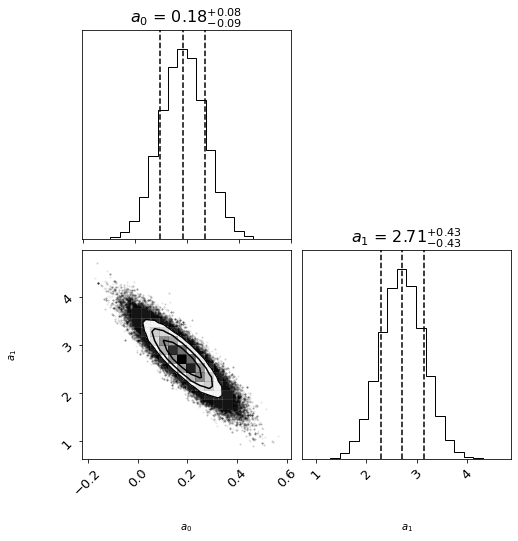

In [274]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
corner.corner(trace_unif500_k1.T, labels=[r"$a_0$", r"$a_1$"],
              quantiles=[0.16, 0.5, 0.84], fig=fig,show_titles=True, 
              title_kwargs={"fontsize": 16});
for ax in fig.get_axes():  
      ax.tick_params(axis='both', labelsize=13)

Similar to what we saw in linear regression notebook, since the EFT model in this case is just a linear model, $a_0 + a_1x$, the two parameters are negatively correlated. The marginal posterior distribution plots for both parameters have smaller widths than their estimated values, implying that there is no overfitting. However, with only two parameters, the current model is likely to underfit, although this is not apparent from the posterior plot.

##### Gaussian Prior ($k = k_{\max} = 1$)

To re-iterate, we use here the uniform prior of the form
$$Pr(\mathbf{a},\mathbf{a}_{\text{marg}}|a_{\text{fix}},k,k_{\max}) = \prod_{i=1}^{k_{\max}}\left[\frac{1}{a_{\text{fix}}\sqrt{2\pi}}\right] \exp\left[- \sum_{i=1}^{k_{\max}}\frac{a_i^2}{2 a^2_{\text{fix}}}\right]\;,\;\;\;\forall i\in\{0,1,\ldots,k_{\max}\}.$$
In particular, we take $a_{\text{fix}} = 5$, so that the prior supposedly restraint the estimated parameters to smaller values.

In [275]:
trace_gauss5_k1, lnprob_gauss5_k1 = MCMC_runner(x_paper, y_paper, sigma_paper, k_max=1, a_fix=5, gaussian=True)

emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
CPU times: user 28.7 s, sys: 101 ms, total: 28.8 s
Wall time: 28.9 s
done


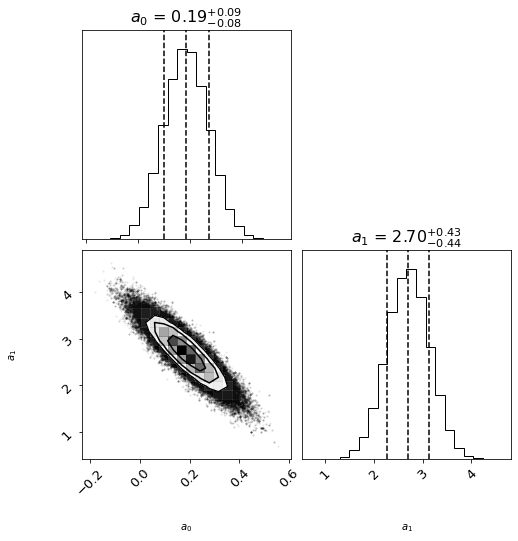

In [276]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
corner.corner(trace_gauss5_k1.T, labels=[r"$a_0$", r"$a_1$"],
              quantiles=[0.16, 0.5, 0.84], fig=fig,show_titles=True, 
              title_kwargs={"fontsize": 16});
for ax in fig.get_axes():  
      ax.tick_params(axis='both', labelsize=13)

The results are very similar to the 2-parameter case with the uniform prior, although in this case the Gaussian prior significantly restricts the parameter estimates to small values. This is another evidence to support that the estimates at $k=k_{\max}=1$ are not overfitting.

##### Uniform Prior ($k = k_{\max}=3$)

The MCMC is run below followed by the corner plot.

In [277]:
trace_unif500_k3, lnprob_unif500_k3 = MCMC_runner(x_paper, y_paper, sigma_paper, k_max=3, a_fix=500, gaussian=False)

emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
CPU times: user 33 s, sys: 115 ms, total: 33.1 s
Wall time: 33.3 s
done


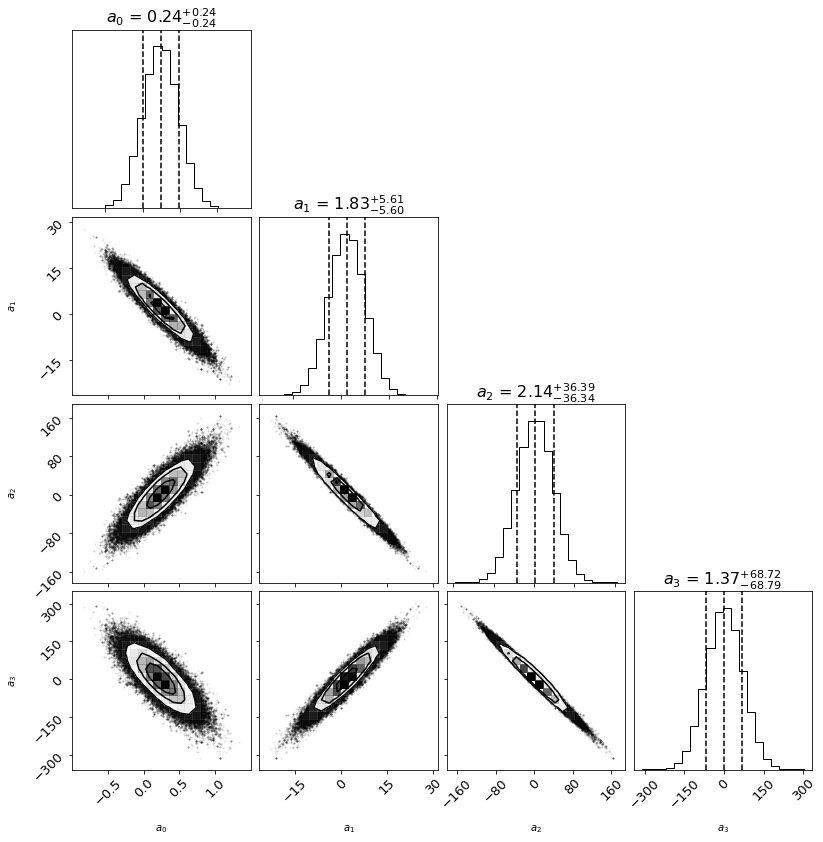

In [278]:
fig, ax = plt.subplots(4,4, figsize=(12,12))
corner.corner(trace_unif500_k3.T, labels=[r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"],
              quantiles=[0.16, 0.5, 0.84], fig=fig,show_titles=True, 
              title_kwargs={"fontsize": 16});
for ax in fig.get_axes():  
      ax.tick_params(axis='both', labelsize=13)

We see high correlations between all pairs of parameters. In particular, the correlations are positive(negative) for parameters that are of even(odd) distances apart in the corresponding power of $x$, which makes sense if we either look at the resulting model curve or extend the logic behind the negative correlation in linear model fits. 
<br><br>
Also, starting from $a_1$ and more severely for $a_2$ and $a_3$, we see that the widths of the histograms are extremely large compared to their estimated values. Furthermore, if we run MCMC several times, we will get quite different parameter estimates, which are not unexpected given the widths of their posterior distributions. These large standard deviations in the parameters' posterior distributions is a symptom of overfitting. 
<br><br>
The broad uniform prior we are using here is especially prone to overfitting because the parameter estimates are controlled almost entirely by the data as oppose to the prior. In fact, this model corresponds to the frequentist's polynomial regression with no regularization, which is a model known to be prone to overfitting.

##### Gaussian Prior ($k = k_{\max}=3$)

The MCMC is run below followed by the corner plot.

In [279]:
trace_gauss5_k3, lnprob_gauss5_k3 = MCMC_runner(x_paper, y_paper, sigma_paper, k_max=3, a_fix=5, gaussian=True)

emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
CPU times: user 31.4 s, sys: 63.6 ms, total: 31.4 s
Wall time: 31.5 s
done


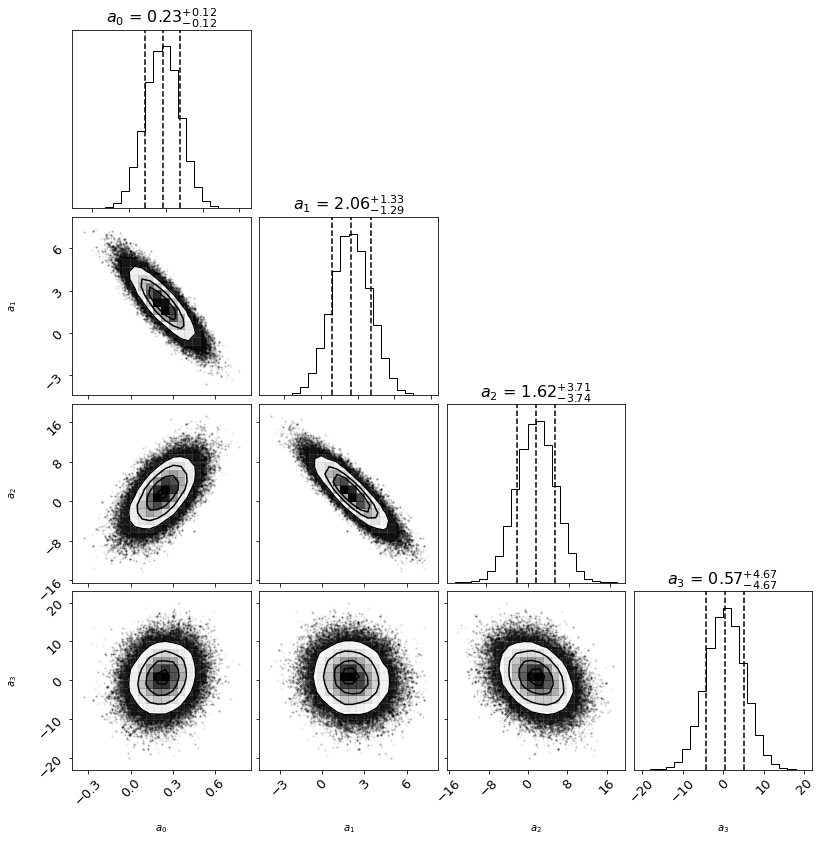

In [280]:
fig, ax = plt.subplots(4,4, figsize=(12,12))
corner.corner(trace_gauss5_k3.T, labels=[r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"],
              quantiles=[0.16, 0.5, 0.84], fig=fig,show_titles=True, 
              title_kwargs={"fontsize": 16});
for ax in fig.get_axes():  
      ax.tick_params(axis='both', labelsize=13)

In this case, the correlations between parameters are not as strong. For $a_3$, its correlation with any other parameter is close to zero. Furthermore, when we look at the histograms for $a_2$ and $a_3$, the standard deviations are close to $a_{\text{fix}}=5$ while their estimated values are less than 5. This implies that their posterior distributions are largely determined by the prior distribution, which restricts the parameter estimates to smaller values as oppose to large values dictated by the data (c.f. the uniform prior case). One can say that in this case "the prior is returned."
<br><br>
Using a Gaussian prior with appropriate weight is a more systematic way to constraint the fitted parameters in our model to conform with the background physical knowledge. An equivalent feature in the frequentist approach is regularization or the lasso, which would require us to fine-tune a hyperparameter that quantifies the penalty we want to give to large parameter estimates. While both methods require us to give at least one extra parameter in order to perform the fit, the hyperparameter for the frequestist's method is not as clearly related to physical situation and hence more difficult to tune it based on the background physical knowledge.

### Results

In this section, we run the MCMC simutation using (1) broad uniform prior ($a_{\text{fix}}=500$), (2) restrictive uniform prior ($a_{\text{fix}}=5$) and (3) Gaussian prior ($a_{\text{fix}}=5$), using different values of $k$ and $k_{\max}$. The relevant code is shown below, followed by the table listing the parameter estimates that result. 
<br><br>
Since the marginal posterior distribution for each parameter is close to Gaussian, using mean, median or mode as our parameter estimates should not make significant difference. In the table, we report the median plus/minus 34 percentiles in order to get the mean plus/minus one standard deviation if the marginal distribution were exactly Gaussian.

In [28]:
k_max_max = 6     # Perform the fit for k_max = 0,1,...,6
k_upto = 2        # For each k_max, report the fit for up to a_0 ,..., a_{min(k_max,2)}
n_walkers = 50    # MCMC parameters setup
n_steps = 5000
n_warmups = 500
LB_percentile = 0.16     # Position of the lower bound for the confidence interval
UB_percentile = 0.84     # Position of the upper bound for the confidence interval
medians = np.array([[[0.0 for j in range(3)] for i in range(k_upto + 1)] for m in range(k_max_max + 1)])
plus = np.array([[[0.0 for j in range(3)] for i in range(k_upto + 1)] for m in range(k_max_max + 1)])
minus = np.array([[[0.0 for j in range(3)] for i in range(k_upto + 1)] for m in range(k_max_max + 1)])
for km in range(k_max_max + 1):
    print("Broad Uniform Prior, k = %d, k_max = %d:" % (min(km, k_upto), km))
    trace, lnprob = MCMC_runner(x_paper, y_paper, sigma_paper, k_max=km, a_fix=500, gaussian=False,
                                nwalkers=n_walkers, nsteps=n_steps, nwarmups=n_warmups);
    print("-------------------------")
    for j in range(min(km, k_upto) + 1):
        params = np.sort(trace[j])
        length = (n_steps - n_warmups) * n_walkers
        median = params[length // 2]
        LB = params[int(LB_percentile * length)]
        UB = params[int(UB_percentile * length)]
        medians[km][j][0] = median
        plus[km][j][0] = UB - median
        minus[km][j][0] = median - LB
        print("Estimated a_%d: %.3f (-%.3f, +%.3f)" % (j, median, median - LB, UB - median))
    print()
    print("Restrictive Uniform Prior, k = %d, k_max = %d:" % (min(km, k_upto), km))
    trace, lnprob = MCMC_runner(x_paper, y_paper, sigma_paper, k_max=km, a_fix=5, gaussian=False,
                                nwalkers=n_walkers, nsteps=n_steps, nwarmups=n_warmups);
    print("-------------------------")
    for j in range(min(km, k_upto) + 1):
        params = np.sort(trace[j])
        length = (n_steps - n_warmups) * n_walkers
        median = params[length // 2]
        LB = params[int(LB_percentile * length)]
        UB = params[int(UB_percentile * length)]
        medians[km][j][1] = median
        plus[km][j][1] = UB - median
        minus[km][j][1] = median - LB
        print("Estimated a_%d: %.3f (-%.3f, +%.3f)" % (j, median, median - LB, UB - median))
    print()
    print("Gaussian Prior, k = %d, k_max = %d:" % (min(km, k_upto), km))
    trace, lnprob = MCMC_runner(x_paper, y_paper, sigma_paper, k_max=km, a_fix=5, gaussian=True,
                                nwalkers=n_walkers, nsteps=n_steps, nwarmups=n_warmups);
    print("-------------------------")
    for j in range(min(km, k_upto) + 1):
        params = np.sort(trace[j])
        length = (n_steps - n_warmups) * n_walkers
        median = params[length // 2]
        LB = params[int(LB_percentile * length)]
        UB = params[int(UB_percentile * length)]
        medians[km][j][2] = median
        plus[km][j][2] = UB - median
        minus[km][j][2] = median - LB
        print("Estimated a_%d: %.3f (-%.3f, +%.3f)" % (j, median, median - LB, UB - median))
    print()

Broad Uniform Prior, k = 0, k_max = 0:
emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
CPU times: user 24.8 s, sys: 64.9 ms, total: 24.9 s
Wall time: 24.9 s
done
-------------------------
Estimated a_0: 0.658 (-0.040, +0.040)

Restrictive Uniform Prior, k = 0, k_max = 0:
emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
CPU times: user 23.5 s, sys: 35 ms, total: 23.5 s
Wall time: 23.5 s
done
-------------------------
Estimated a_0: 0.658 (-0.039, +0.040)

Gaussian Prior, k = 0, k_max = 0:
emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
CPU times: user 23.3 s, sys: 38.1 ms, total: 23.3 s
Wall time: 23.4 s
done
-------------------------
Estimated a_0: 0.658 (-0.040, +0.039)

Broad Uniform Prior, k = 1, k_max = 1:
emcee sampling (version: ) 2.2.1
50 walkers: 5000 samples each
CPU times: user 25.6 s, sys: 32.1 ms, total: 25.6 s
Wall time: 25.6 s
done
-------------------------
Estimated a_0: 0.182 (-0.084, +0.085)
Estimated a_1: 2.724 (-0.427, +0.4

Here are the coefficient estimates for the broad uniform prior ($a_{\text{fix}} = 500$).

| <div style="width:50px">$k$</div> | <div style="width:50px">$k_{\max}$</div> | <div style="width:150px">$a_0$</div> | <div style="width:150px">$a_1$</div> | <div style="width:150px">$a_2$</div> |
| :-: | :-: | :-: | :-: | :-: |
| 0 | 0 | 0.658 (-0.040, +0.040) |  |  | 
| 1 | 1 | 0.182 (-0.084, +0.085) | 2.724 (-0.427, +0.429) | | 
| 2 | 2 | 0.248 (-0.148, +0.150) | 1.694 (-1.939, +1.944) | 2.925 (-5.411, +5.373) |
| 2 | 3 | 0.241 (-0.242, +0.243) | 1.855 (-5.730, +5.690) | 1.844 (-36.889, +37.312) |
| 2 | 4 | 0.241 (-0.260, +0.264) | 1.863 (-7.023, +7.008) | 2.029 (-62.556, +61.630) |
| 2 | 5 | 0.247 (-0.274, +0.269) | 1.780 (-7.393, +7.482) | 1.416 (-65.532, +66.171) |
| 2 | 6 | 0.233 (-0.260, +0.271) | 2.066 (-7.243, +7.298) | 0.552 (-64.519, +63.927) |
| Actual || 0.25 | 1.57 | 2.47 |

Here are the coefficient estimates for the restrictive uniform prior ($a_{\text{fix}} = 5$).

| <div style="width:50px">$k$</div> | <div style="width:50px">$k_{\max}$</div> | <div style="width:150px">$a_0$</div> | <div style="width:150px">$a_1$</div> | <div style="width:150px">$a_2$</div> |
| :-: | :-: | :-: | :-: | :-: |
| 0 | 0 | 0.658 (-0.039, +0.040) |  |  | 
| 1 | 1 | 0.182 (-0.084, +0.084) | 2.717 (-0.433, +0.429) | | 
| 2 | 2 | 0.201 (-0.105, +0.103) | 2.379 (-0.999, +1.176) | 1.076 (-3.356, +2.650) |
| 2 | 3 | 0.202 (-0.107, +0.105) | 2.381 (-1.034, +1.188) | 0.928 (-3.339, +2.808) |
| 2 | 4 | 0.200 (-0.104, +0.107) | 2.374 (-1.025, +1.172) | 0.950 (-3.347, +2.744) |
| 2 | 5 | 0.203 (-0.109, +0.103) | 2.384 (-1.001, +1.172) | 0.921 (-3.290, +2.716) |
| 2 | 6 | 0.208 (-0.110, +0.108) | 2.389 (-1.032, +1.167) | 0.806 (-3.380, +2.785) |
| Actual || 0.25 | 1.57 | 2.47 |

Here are the coefficient estimates for the Gaussian prior ($a_{\text{fix}} = 5$).

| <div style="width:50px">$k$</div> | <div style="width:50px">$k_{\max}$</div> | <div style="width:150px">$a_0$</div> | <div style="width:150px">$a_1$</div> | <div style="width:150px">$a_2$</div> |
| :-: | :-: | :-: | :-: | :-: |
| 0 | 0 | 0.658 (-0.040, +0.039) |  |  | 
| 1 | 1 | 0.187 (-0.085, +0.086) | 2.696 (-0.431, +0.427) | | 
| 2 | 2 | 0.222 (-0.116, +0.117) | 2.123 (-1.324, +1.297) | 1.673 (-3.518, +3.556) |
| 2 | 3 | 0.226 (-0.114, +0.114) | 2.109 (-1.286, +1.287) | 1.476 (-3.678, +3.694) |
| 2 | 4 | 0.227 (-0.116, +0.115) | 2.097 (-1.298, +1.297) | 1.453 (-3.749, +3.678) |
| 2 | 5 | 0.228 (-0.118, +0.115) | 2.067 (-1.283, +1.304) | 1.557 (-3.703, +3.801) |
| 2 | 6 | 0.227 (-0.115, +0.118) | 2.081 (-1.302, +1.296) | 1.543 (-3.739, +3.767) |
| Actual || 0.25 | 1.57 | 2.47 |

As mentioned previously, the broad uniform prior results in severe overfitting starting from $k_{\max}$ of 2 to 3. This is evident from the error bars in the corresponding table. For the restrictive uniform prior and the Gaussian prior, the parameters are well-constrained to small values with the standard deviations not exceeding the prior's width of $a_{\text{fix}}=5$, that is, the parameter estimates are dictated by the prior.
<br><br>
Finally, the reader should notice that these tables are based on the 10 data points generated by the authors of the paper. This is done to as closely reproduce the paper's results as possible. Alternatively, one can use the `generate_data` function written in this notebook to randomly generate as many data points as computationally feasible, which in turn will lead to parameter estimates with smaller standard deviations. The width should roughly decrease with $\sigma\sim 1/\sqrt{N_{\text{data}}}$, modulo the additional random components resulting from MCMC. These larger data sets, together with an appropriate prior, will potentially produce good estimates for the parameters with small standard deviations.

This notebook was created by Josh Tawabutr as a part of Bayesian Analysis Course (Physics 8820) at the Ohio State University. The work is based on the paper: https://arxiv.org/abs/1511.03618.